### ДЗ №10. Машинный перевод Seq2Seq

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2021-05-06 20:51:07--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14042100 (13M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  13,39M  2,62MB/s    in 6,5s    

2021-05-06 20:51:14 (2,06 MB/s) - ‘rus-eng.zip’ saved [14042100/14042100]



In [4]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [3]:
# Download the file
path_to_file = "rus-eng/rus.txt"

In [4]:
def preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
    with open(path, 'r') as f:
        lines = f.read().strip().split('\n')
        word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
        return zip(*word_pairs)

In [7]:
en, ru = create_dataset(path_to_file, None)
print(en[0])
print(ru[0])

<start> go . <end>
<start> марш ! <end>


In [8]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

In [9]:
lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

In [10]:
lang_tokenizer.fit_on_texts(en)

In [11]:
tensor = lang_tokenizer.texts_to_sequences(en)

In [12]:
tensor[:10]

[[1, 40, 3, 2],
 [1, 40, 3, 2],
 [1, 40, 3, 2],
 [1, 2062, 3, 2],
 [1, 2062, 3, 2],
 [1, 2062, 3, 2],
 [1, 2062, 3, 2],
 [1, 2062, 3, 2],
 [1, 517, 207, 2],
 [1, 517, 207, 2]]

In [13]:
en[:10]

('<start> go . <end>',
 '<start> go . <end>',
 '<start> go . <end>',
 '<start> hi . <end>',
 '<start> hi . <end>',
 '<start> hi . <end>',
 '<start> hi . <end>',
 '<start> hi . <end>',
 '<start> run ! <end>',
 '<start> run ! <end>')

In [14]:
tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

In [15]:
tensor[:10]

array([[   1,   40,    3, ...,    0,    0,    0],
       [   1,   40,    3, ...,    0,    0,    0],
       [   1,   40,    3, ...,    0,    0,    0],
       ...,
       [   1, 2062,    3, ...,    0,    0,    0],
       [   1,  517,  207, ...,    0,    0,    0],
       [   1,  517,  207, ...,    0,    0,    0]], dtype=int32)

In [16]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [17]:
# Пробуем урезанный набор
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples=100000)

In [18]:
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [19]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [20]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [21]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
7 ----> не
152 ----> будь
427 ----> таким
15645 ----> скромным
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
20 ----> don't
33 ----> be
57 ----> so
1344 ----> modest
3 ----> .
2 ----> <end>


In [22]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [23]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [24]:
example_input_batch[0]

<tf.Tensor: shape=(15,), dtype=int32, numpy=
array([    1,    13,    91, 13233, 13234,     3,     2,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)>

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=False,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [47]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [48]:
# sample input
sample_hidden = encoder.initialize_hidden_state()

In [49]:
sample_hidden

<tf.Tensor: shape=(32, 1024), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [50]:
output = encoder(example_input_batch, sample_hidden)

In [51]:
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder Hidden state shape: (batch size, units) (32, 1024)


In [52]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state

In [53]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)

In [54]:
embedding_dim

600

In [55]:
decoder_sample_x.shape

TensorShape([32, 7148])

In [56]:
decoder_sample_h.shape

TensorShape([32, 1024])

In [57]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [58]:
checkpoint_dir = './training_nmt_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [59]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden = decoder(dec_input, dec_hidden)
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [60]:
EPOCHS = 50
history = []

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    history.append(total_loss / steps_per_epoch)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.3874
Epoch 1 Batch 100 Loss 1.9032
Epoch 1 Batch 200 Loss 1.8065
Epoch 1 Batch 300 Loss 1.7103
Epoch 1 Batch 400 Loss 1.5340
Epoch 1 Batch 500 Loss 1.5236
Epoch 1 Batch 600 Loss 1.4728
Epoch 1 Batch 700 Loss 1.4109
Epoch 1 Batch 800 Loss 1.5301
Epoch 1 Batch 900 Loss 1.4389
Epoch 1 Batch 1000 Loss 1.2556
Epoch 1 Batch 1100 Loss 1.1250
Epoch 1 Batch 1200 Loss 1.1788
Epoch 1 Batch 1300 Loss 1.1426
Epoch 1 Batch 1400 Loss 1.0857
Epoch 1 Batch 1500 Loss 0.8992
Epoch 1 Batch 1600 Loss 0.9798
Epoch 1 Batch 1700 Loss 0.7227
Epoch 1 Batch 1800 Loss 0.9664
Epoch 1 Batch 1900 Loss 0.8754
Epoch 1 Batch 2000 Loss 0.7887
Epoch 1 Batch 2100 Loss 0.8444
Epoch 1 Batch 2200 Loss 0.6634
Epoch 1 Batch 2300 Loss 0.9127
Epoch 1 Batch 2400 Loss 0.6314
Epoch 1 Loss 1.2216
Time taken for 1 epoch 245.95407557487488 sec

Epoch 2 Batch 0 Loss 0.4962
Epoch 2 Batch 100 Loss 0.5377
Epoch 2 Batch 200 Loss 0.5202
Epoch 2 Batch 300 Loss 0.5390
Epoch 2 Batch 400 Loss 0.5798
Epoch 2 Batch 500 Loss

Epoch 10 Batch 2300 Loss 0.0579
Epoch 10 Batch 2400 Loss 0.0793
Epoch 10 Loss 0.0830
Time taken for 1 epoch 232.00938510894775 sec

Epoch 11 Batch 0 Loss 0.0315
Epoch 11 Batch 100 Loss 0.0237
Epoch 11 Batch 200 Loss 0.0741
Epoch 11 Batch 300 Loss 0.0723
Epoch 11 Batch 400 Loss 0.0123
Epoch 11 Batch 500 Loss 0.0438
Epoch 11 Batch 600 Loss 0.0898
Epoch 11 Batch 700 Loss 0.0659
Epoch 11 Batch 800 Loss 0.0324
Epoch 11 Batch 900 Loss 0.1005
Epoch 11 Batch 1000 Loss 0.0645
Epoch 11 Batch 1100 Loss 0.0904
Epoch 11 Batch 1200 Loss 0.0815
Epoch 11 Batch 1300 Loss 0.0657
Epoch 11 Batch 1400 Loss 0.0693
Epoch 11 Batch 1500 Loss 0.0941
Epoch 11 Batch 1600 Loss 0.0972
Epoch 11 Batch 1700 Loss 0.0830
Epoch 11 Batch 1800 Loss 0.0785
Epoch 11 Batch 1900 Loss 0.0430
Epoch 11 Batch 2000 Loss 0.0824
Epoch 11 Batch 2100 Loss 0.1957
Epoch 11 Batch 2200 Loss 0.1699
Epoch 11 Batch 2300 Loss 0.1327
Epoch 11 Batch 2400 Loss 0.1100
Epoch 11 Loss 0.0806
Time taken for 1 epoch 233.65664052963257 sec

Epoch 12 Bat

Epoch 20 Batch 1200 Loss 0.0668
Epoch 20 Batch 1300 Loss 0.0466
Epoch 20 Batch 1400 Loss 0.0944
Epoch 20 Batch 1500 Loss 0.0295
Epoch 20 Batch 1600 Loss 0.1282
Epoch 20 Batch 1700 Loss 0.0184
Epoch 20 Batch 1800 Loss 0.0759
Epoch 20 Batch 1900 Loss 0.0446
Epoch 20 Batch 2000 Loss 0.1345
Epoch 20 Batch 2100 Loss 0.1232
Epoch 20 Batch 2200 Loss 0.0329
Epoch 20 Batch 2300 Loss 0.0600
Epoch 20 Batch 2400 Loss 0.0826
Epoch 20 Loss 0.0681
Time taken for 1 epoch 235.09851789474487 sec

Epoch 21 Batch 0 Loss 0.0625
Epoch 21 Batch 100 Loss 0.0274
Epoch 21 Batch 200 Loss 0.0417
Epoch 21 Batch 300 Loss 0.0990
Epoch 21 Batch 400 Loss 0.0543
Epoch 21 Batch 500 Loss 0.0860
Epoch 21 Batch 600 Loss 0.1199
Epoch 21 Batch 700 Loss 0.0367
Epoch 21 Batch 800 Loss 0.1019
Epoch 21 Batch 900 Loss 0.0578
Epoch 21 Batch 1000 Loss 0.0549
Epoch 21 Batch 1100 Loss 0.0484
Epoch 21 Batch 1200 Loss 0.0760
Epoch 21 Batch 1300 Loss 0.0581
Epoch 21 Batch 1400 Loss 0.0889
Epoch 21 Batch 1500 Loss 0.0578
Epoch 21 Batch 1

Epoch 30 Batch 100 Loss 0.0181
Epoch 30 Batch 200 Loss 0.0348
Epoch 30 Batch 300 Loss 0.0641
Epoch 30 Batch 400 Loss 0.0475
Epoch 30 Batch 500 Loss 0.0802
Epoch 30 Batch 600 Loss 0.0523
Epoch 30 Batch 700 Loss 0.0565
Epoch 30 Batch 800 Loss 0.0251
Epoch 30 Batch 900 Loss 0.0422
Epoch 30 Batch 1000 Loss 0.0854
Epoch 30 Batch 1100 Loss 0.0576
Epoch 30 Batch 1200 Loss 0.0588
Epoch 30 Batch 1300 Loss 0.0505
Epoch 30 Batch 1400 Loss 0.0508
Epoch 30 Batch 1500 Loss 0.0506
Epoch 30 Batch 1600 Loss 0.0882
Epoch 30 Batch 1700 Loss 0.0750
Epoch 30 Batch 1800 Loss 0.0744
Epoch 30 Batch 1900 Loss 0.0875
Epoch 30 Batch 2000 Loss 0.0747
Epoch 30 Batch 2100 Loss 0.0511
Epoch 30 Batch 2200 Loss 0.0985
Epoch 30 Batch 2300 Loss 0.1134
Epoch 30 Batch 2400 Loss 0.1830
Epoch 30 Loss 0.0642
Time taken for 1 epoch 233.25964164733887 sec

Epoch 31 Batch 0 Loss 0.0591
Epoch 31 Batch 100 Loss 0.0284
Epoch 31 Batch 200 Loss 0.0225
Epoch 31 Batch 300 Loss 0.0307
Epoch 31 Batch 400 Loss 0.0230
Epoch 31 Batch 500 L

Epoch 39 Batch 1700 Loss 0.0478
Epoch 39 Batch 1800 Loss 0.0656
Epoch 39 Batch 1900 Loss 0.0784
Epoch 39 Batch 2000 Loss 0.0388
Epoch 39 Batch 2100 Loss 0.0579
Epoch 39 Batch 2200 Loss 0.0468
Epoch 39 Batch 2300 Loss 0.1291
Epoch 39 Batch 2400 Loss 0.0512
Epoch 39 Loss 0.0641
Time taken for 1 epoch 238.52123069763184 sec

Epoch 40 Batch 0 Loss 0.0408
Epoch 40 Batch 100 Loss 0.0133
Epoch 40 Batch 200 Loss 0.0305
Epoch 40 Batch 300 Loss 0.0645
Epoch 40 Batch 400 Loss 0.0348
Epoch 40 Batch 500 Loss 0.0997
Epoch 40 Batch 600 Loss 0.0973
Epoch 40 Batch 700 Loss 0.0744
Epoch 40 Batch 800 Loss 0.0940
Epoch 40 Batch 900 Loss 0.0186
Epoch 40 Batch 1000 Loss 0.0591
Epoch 40 Batch 1100 Loss 0.1070
Epoch 40 Batch 1200 Loss 0.0785
Epoch 40 Batch 1300 Loss 0.0873
Epoch 40 Batch 1400 Loss 0.0808
Epoch 40 Batch 1500 Loss 0.0896
Epoch 40 Batch 1600 Loss 0.0435
Epoch 40 Batch 1700 Loss 0.1310
Epoch 40 Batch 1800 Loss 0.0680
Epoch 40 Batch 1900 Loss 0.0421
Epoch 40 Batch 2000 Loss 0.1065
Epoch 40 Batch 2

Epoch 49 Batch 600 Loss 0.0517
Epoch 49 Batch 700 Loss 0.0186
Epoch 49 Batch 800 Loss 0.0423
Epoch 49 Batch 900 Loss 0.0443
Epoch 49 Batch 1000 Loss 0.0582
Epoch 49 Batch 1100 Loss 0.0440
Epoch 49 Batch 1200 Loss 0.0848
Epoch 49 Batch 1300 Loss 0.1002
Epoch 49 Batch 1400 Loss 0.0376
Epoch 49 Batch 1500 Loss 0.0605
Epoch 49 Batch 1600 Loss 0.0362
Epoch 49 Batch 1700 Loss 0.1016
Epoch 49 Batch 1800 Loss 0.0655
Epoch 49 Batch 1900 Loss 0.0957
Epoch 49 Batch 2000 Loss 0.0466
Epoch 49 Batch 2100 Loss 0.0801
Epoch 49 Batch 2200 Loss 0.0440
Epoch 49 Batch 2300 Loss 0.0628
Epoch 49 Batch 2400 Loss 0.1310
Epoch 49 Loss 0.0647
Time taken for 1 epoch 236.33838558197021 sec

Epoch 50 Batch 0 Loss 0.0635
Epoch 50 Batch 100 Loss 0.0557
Epoch 50 Batch 200 Loss 0.0405
Epoch 50 Batch 300 Loss 0.0949
Epoch 50 Batch 400 Loss 0.0441
Epoch 50 Batch 500 Loss 0.0427
Epoch 50 Batch 600 Loss 0.0200
Epoch 50 Batch 700 Loss 0.0538
Epoch 50 Batch 800 Loss 0.0677
Epoch 50 Batch 900 Loss 0.0738
Epoch 50 Batch 1000 

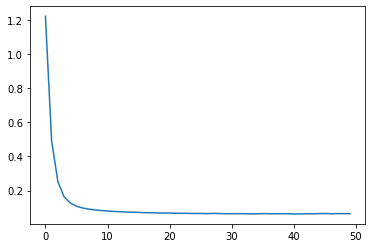

In [62]:
plt.plot(history)

In [63]:
def evaluate(sentence):
    # attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden = decoder(dec_input, dec_hidden)

        # storing the attention weights to plot later on
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [64]:
def translate(sentence):
    result, sentence = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [65]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [66]:
translate('Здесь хорошо.')

Input: <start> здесь хорошо . <end>
Predicted translation: it's good here . <end> 


In [67]:
translate('Пойдем гулять')

Input: <start> пойдем гулять <end>
Predicted translation: let's go for a walk . <end> 


In [68]:
# Точку придумал сам )

In [73]:
translate('бумажное мыло')

Input: <start> бумажное мыло <end>
Predicted translation: the salt ran out . <end> 


In [74]:
# Хаха

In [88]:
translate('Температура Земли в 2020 году поднялась до высокой величины')

Input: <start> температура земли в году поднялась до высокой величины <end>
Predicted translation: let's eat at wear candle . <end> 


In [83]:
# Чушь какая ))

In [84]:
translate('Я не смогу поехать.')

Input: <start> я не смогу поехать . <end>
Predicted translation: i can't go . <end> 


In [85]:
translate(u'Я люблю, когда идет снег.')

Input: <start> я люблю , когда идет снег . <end>
Predicted translation: i like i enjoy snow . <end> 


In [86]:
translate(u'Я никогда такого не делаю.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i never do that . <end> 


## Хочется попробовать LSTM
Если я правильно понял, чтобы инициализировать hidden state у LSTM нужно подать две матрицы - собственно hidden state и cell state

In [24]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                        return_sequences=False,
                                        return_state=True
                                        )

    def call(self, x, hidden, cell_state):
        x = self.embedding(x)
        _, output, state = self.lstm(x, initial_state = [hidden, cell_state])
        return state, output

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [25]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       )
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, hidden, cell_state):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

        # passing the concatenated vector to the GRU
        _, state, output = self.lstm(x, initial_state=[hidden, cell_state])
        
        cell_state = output

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[1]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, cell_state

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [28]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [29]:
checkpoint_dir = './training_nmt_checkpoints_lstm'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [32]:
@tf.function
def train_step(inp, targ, enc_hidden, cell_state):
    loss = 0

    with tf.GradientTape() as tape:
        enc_hidden, cell_state = encoder(inp, enc_hidden, cell_state)
        dec_hidden = enc_hidden
        dec_cell_state = cell_state
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, dec_cell_state = decoder(dec_input, dec_hidden, dec_cell_state)
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [33]:
EPOCHS = 50
history = []

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    history.append(total_loss / steps_per_epoch)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4623
Epoch 1 Batch 100 Loss 2.0388
Epoch 1 Batch 200 Loss 1.8659
Epoch 1 Batch 300 Loss 1.6389
Epoch 1 Batch 400 Loss 1.5603
Epoch 1 Batch 500 Loss 1.4125
Epoch 1 Batch 600 Loss 1.3921
Epoch 1 Batch 700 Loss 1.3487
Epoch 1 Batch 800 Loss 1.2902
Epoch 1 Batch 900 Loss 1.2504
Epoch 1 Batch 1000 Loss 1.1972
Epoch 1 Batch 1100 Loss 1.3157
Epoch 1 Batch 1200 Loss 1.0904
Epoch 1 Loss 1.4622
Time taken for 1 epoch 77.26845145225525 sec

Epoch 2 Batch 0 Loss 0.9644
Epoch 2 Batch 100 Loss 0.9390
Epoch 2 Batch 200 Loss 0.9484
Epoch 2 Batch 300 Loss 0.9596
Epoch 2 Batch 400 Loss 1.0099
Epoch 2 Batch 500 Loss 0.7592
Epoch 2 Batch 600 Loss 0.8169
Epoch 2 Batch 700 Loss 0.7303
Epoch 2 Batch 800 Loss 0.7786
Epoch 2 Batch 900 Loss 0.7135
Epoch 2 Batch 1000 Loss 0.7258
Epoch 2 Batch 1100 Loss 0.7379
Epoch 2 Batch 1200 Loss 0.6805
Epoch 2 Loss 0.8125
Time taken for 1 epoch 67.22707343101501 sec

Epoch 3 Batch 0 Loss 0.5475
Epoch 3 Batch 100 Loss 0.4539
Epoch 3 Batch 200 Loss 0.425

Epoch 18 Batch 1100 Loss 0.0631
Epoch 18 Batch 1200 Loss 0.0449
Epoch 18 Loss 0.0552
Time taken for 1 epoch 67.56506013870239 sec

Epoch 19 Batch 0 Loss 0.0537
Epoch 19 Batch 100 Loss 0.0351
Epoch 19 Batch 200 Loss 0.0353
Epoch 19 Batch 300 Loss 0.0330
Epoch 19 Batch 400 Loss 0.0661
Epoch 19 Batch 500 Loss 0.0236
Epoch 19 Batch 600 Loss 0.0437
Epoch 19 Batch 700 Loss 0.0761
Epoch 19 Batch 800 Loss 0.0417
Epoch 19 Batch 900 Loss 0.0562
Epoch 19 Batch 1000 Loss 0.0439
Epoch 19 Batch 1100 Loss 0.0627
Epoch 19 Batch 1200 Loss 0.0981
Epoch 19 Loss 0.0529
Time taken for 1 epoch 67.16303253173828 sec

Epoch 20 Batch 0 Loss 0.0365
Epoch 20 Batch 100 Loss 0.0403
Epoch 20 Batch 200 Loss 0.0728
Epoch 20 Batch 300 Loss 0.0348
Epoch 20 Batch 400 Loss 0.0810
Epoch 20 Batch 500 Loss 0.0609
Epoch 20 Batch 600 Loss 0.0182
Epoch 20 Batch 700 Loss 0.0512
Epoch 20 Batch 800 Loss 0.0343
Epoch 20 Batch 900 Loss 0.0653
Epoch 20 Batch 1000 Loss 0.0535
Epoch 20 Batch 1100 Loss 0.0542
Epoch 20 Batch 1200 Loss 0

Epoch 36 Batch 300 Loss 0.0299
Epoch 36 Batch 400 Loss 0.0280
Epoch 36 Batch 500 Loss 0.0308
Epoch 36 Batch 600 Loss 0.0182
Epoch 36 Batch 700 Loss 0.0326
Epoch 36 Batch 800 Loss 0.0380
Epoch 36 Batch 900 Loss 0.0613
Epoch 36 Batch 1000 Loss 0.0302
Epoch 36 Batch 1100 Loss 0.0522
Epoch 36 Batch 1200 Loss 0.0496
Epoch 36 Loss 0.0364
Time taken for 1 epoch 67.1742742061615 sec

Epoch 37 Batch 0 Loss 0.0206
Epoch 37 Batch 100 Loss 0.0324
Epoch 37 Batch 200 Loss 0.0294
Epoch 37 Batch 300 Loss 0.0399
Epoch 37 Batch 400 Loss 0.0306
Epoch 37 Batch 500 Loss 0.0174
Epoch 37 Batch 600 Loss 0.0356
Epoch 37 Batch 700 Loss 0.0643
Epoch 37 Batch 800 Loss 0.0548
Epoch 37 Batch 900 Loss 0.0780
Epoch 37 Batch 1000 Loss 0.0348
Epoch 37 Batch 1100 Loss 0.0654
Epoch 37 Batch 1200 Loss 0.0427
Epoch 37 Loss 0.0362
Time taken for 1 epoch 66.86538481712341 sec

Epoch 38 Batch 0 Loss 0.0194
Epoch 38 Batch 100 Loss 0.0165
Epoch 38 Batch 200 Loss 0.0247
Epoch 38 Batch 300 Loss 0.0184
Epoch 38 Batch 400 Loss 0.02

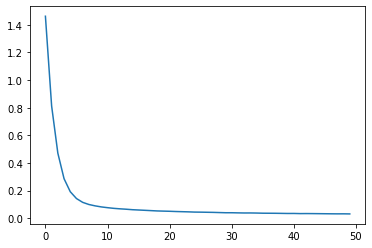

In [35]:
plt.plot(history)
plt.show()

In [36]:
# Это нельзя считать чистым экспериментом, в этот раз использовались эмбеддинги с размерностью 300, в прошлый раз 600

In [37]:
# Но в целом - результат есть, и LSTM удалось завести. Это была цель

In [108]:
def evaluate(sentence):
    # attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden = tf.zeros((1, units))
    enc_hidden, cell_state = encoder(inputs, hidden, hidden)

    dec_hidden = enc_hidden
    dec_cell_state = cell_state
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, dec_cell_state = decoder(dec_input, dec_hidden, dec_cell_state)

        # storing the attention weights to plot later on
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [109]:
def translate(sentence):
    result, sentence = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [111]:
translate('Здесь хорошо.')

Input: <start> здесь хорошо . <end>
Predicted translation: it's good here . <end> 


In [113]:
translate('Пойдем гулять')

Input: <start> пойдем гулять <end>
Predicted translation: come on your shoes . <end> 


In [114]:
translate('бумажное мыло')

Input: <start> бумажное мыло <end>
Predicted translation: get dressed . <end> 


In [115]:
translate('Температура Земли в 2020 году поднялась до высокой величины')

Input: <start> температура земли в году поднялась до высокой величины <end>
Predicted translation: the dog flew away . <end> 


In [116]:
translate('Я не смогу поехать.')

Input: <start> я не смогу поехать . <end>
Predicted translation: i can't go . <end> 


In [117]:
translate(u'Я люблю, когда идет снег.')

Input: <start> я люблю , когда идет снег . <end>
Predicted translation: i like being snow . <end> 


In [118]:
translate(u'Я никогда такого не делаю.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i never do that . <end> 


In [119]:
# Вобщем, +- такое-же качество

## Внимание!

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [26]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [27]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [29]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [30]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [31]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7148)


In [32]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [33]:
checkpoint_dir = './training_checkpoints_a'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [35]:
EPOCHS = 10
history = []

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    history.append(total_loss / steps_per_epoch)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7023
Epoch 1 Batch 100 Loss 2.0831
Epoch 1 Batch 200 Loss 1.8040
Epoch 1 Batch 300 Loss 1.7891
Epoch 1 Batch 400 Loss 1.6611
Epoch 1 Batch 500 Loss 1.4386
Epoch 1 Batch 600 Loss 1.3322
Epoch 1 Batch 700 Loss 1.2326
Epoch 1 Batch 800 Loss 1.2295
Epoch 1 Batch 900 Loss 1.0238
Epoch 1 Batch 1000 Loss 1.0209
Epoch 1 Batch 1100 Loss 0.7808
Epoch 1 Batch 1200 Loss 0.9195
Epoch 1 Loss 1.4401
Time taken for 1 epoch 94.12187957763672 sec

Epoch 2 Batch 0 Loss 0.8246
Epoch 2 Batch 100 Loss 0.7227
Epoch 2 Batch 200 Loss 0.7640
Epoch 2 Batch 300 Loss 0.7682
Epoch 2 Batch 400 Loss 0.6657
Epoch 2 Batch 500 Loss 0.6301
Epoch 2 Batch 600 Loss 0.5891
Epoch 2 Batch 700 Loss 0.5117
Epoch 2 Batch 800 Loss 0.4934
Epoch 2 Batch 900 Loss 0.5631
Epoch 2 Batch 1000 Loss 0.5836
Epoch 2 Batch 1100 Loss 0.4277
Epoch 2 Batch 1200 Loss 0.4260
Epoch 2 Loss 0.6050
Time taken for 1 epoch 87.80953001976013 sec

Epoch 3 Batch 0 Loss 0.4384
Epoch 3 Batch 100 Loss 0.3114
Epoch 3 Batch 200 Loss 0.409

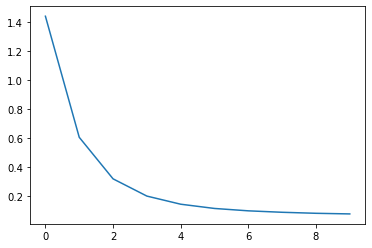

In [36]:
plt.plot(history)
plt.show()

In [37]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [38]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [39]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> здесь хорошо . <end>
Predicted translation: it's fine here . <end> 


<ipython-input-38-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


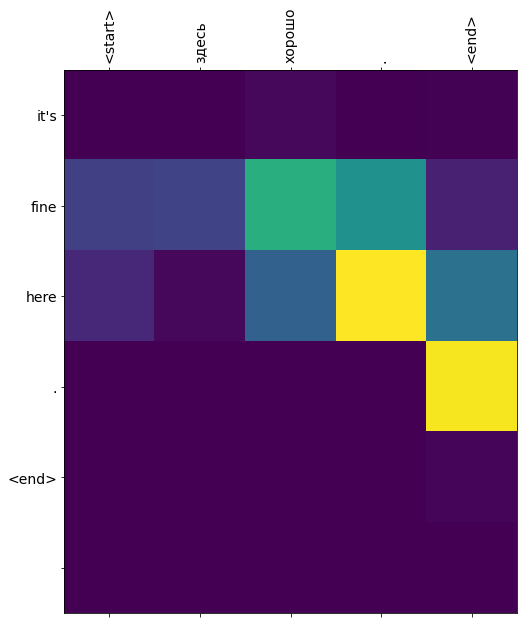

In [40]:
translate('Здесь хорошо.')

Input: <start> пойдем гулять <end>
Predicted translation: let's go for a walk . <end> 


<ipython-input-38-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


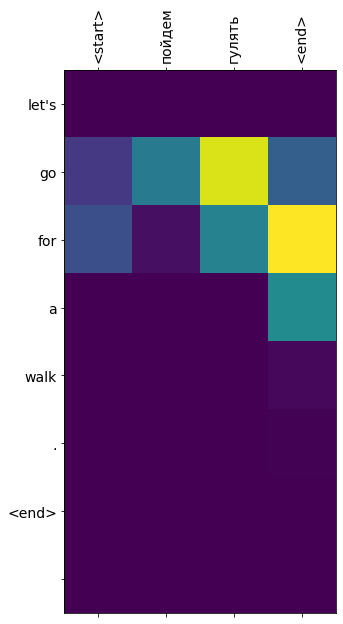

In [41]:
translate('Пойдем гулять')

Input: <start> бумажное мыло <end>
Predicted translation: stir the soup . <end> 


<ipython-input-38-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


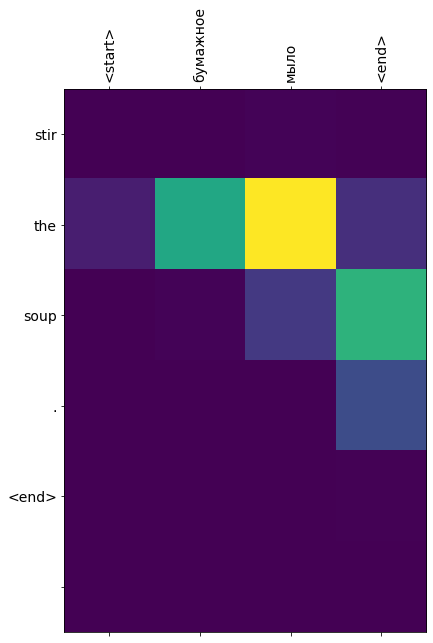

In [42]:
translate('бумажное мыло')

Input: <start> температура земли в году поднялась до высокой величины <end>
Predicted translation: a walk room came at please . <end> 


<ipython-input-38-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


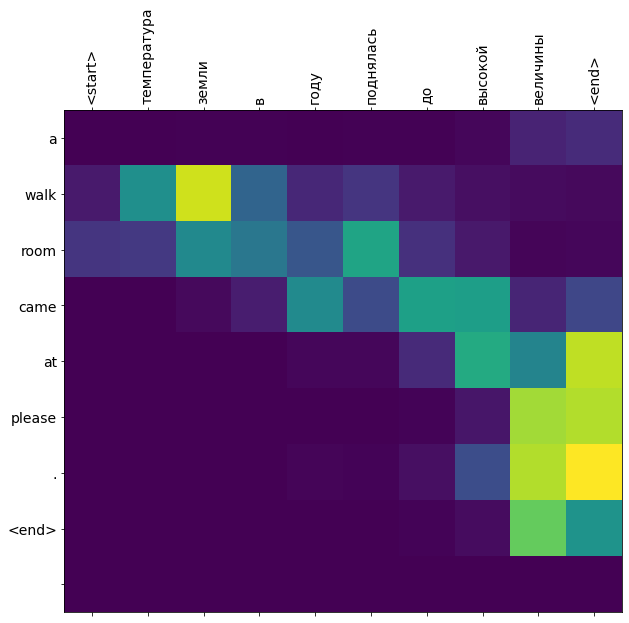

In [43]:
translate('Температура Земли в 2020 году поднялась до высокой величины')

Input: <start> я люблю , когда идет снег . <end>
Predicted translation: i love if it rains . <end> 


<ipython-input-38-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-38-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


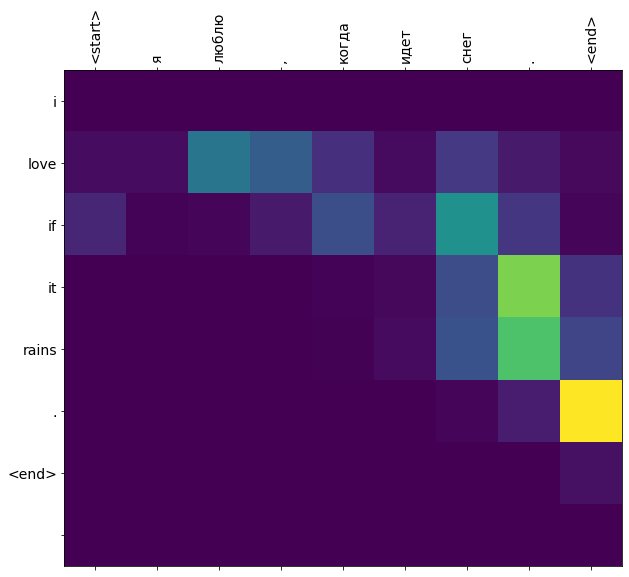

In [44]:
translate(u'Я люблю, когда идет снег.')

In [45]:
# Что-то в этом есть )